# <a id='toc1_'></a>Выбор локации для скважины   [](#toc0_)

# Введение

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три значимых признака точек;
- product — объём запасов в скважине (тыс. баррелей).

# Условия задачи

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Table of contents**<a id='toc0_'></a>    
- [Выбор локации для скважины  ](#toc1_)    
  - [Загрузка и подготовка данных  ](#toc1_1_)    
    - [Создание класса oil_well  ](#toc1_1_1_)    
    - [Создание экземпляров класса  ](#toc1_1_2_)    
    - [Вывод  ](#toc1_1_3_)    
  - [Обучение и проверка модели  ](#toc1_2_)    
    - [train_test_split  ](#toc1_2_1_)    
    - [Scaling  ](#toc1_2_2_)    
    - [Обучение Linear Regression  ](#toc1_2_3_)    
    - [Вывод:  ](#toc1_2_4_)    
  - [Подготовка к расчёту прибыли  ](#toc1_3_)    
    - [Вывод:  ](#toc1_3_1_)    
  - [Расчёт прибыли и рисков  ](#toc1_4_)    
    - [Прибыль  ](#toc1_4_1_)    
    - [Вывод  ](#toc1_4_2_)    
  - [Bootstrap  ](#toc1_5_)    
    - [Вывод:  ](#toc1_5_1_)    
  - [Вывод  ](#toc1_6_)    
        - [a. Обработка данных  ](#toc1_6_1_1_1_)    
        - [b. Разделение данных и обучение модели  ](#toc1_6_1_1_2_)    
        - [c. Подготовительные расчеты  ](#toc1_6_1_1_3_)    
        - [d. Работа модели на тестовых данных  ](#toc1_6_1_1_4_)    
        - [f. Bootstrap  ](#toc1_6_1_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>Загрузка и подготовка данных   [](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats as st

from sklearn.linear_model import LinearRegression

### <a id='toc1_1_1_'></a>Создание класса oil_well   [](#toc0_)

In [2]:
class oil_well_geo_data():
    
    all_oil_well = []
    
    def __init__(self, link:str) -> None:
        try:
            self.data = pd.read_csv(link,index_col='id')
        except:
            print('Не получилось получить данные. Проверьте путь!')
        oil_well_geo_data.all_oil_well.append(self)
        self.num_of_region = len(oil_well_geo_data.all_oil_well)
        return None
    
    def train_valid_split(self, split_size=.25,r_state=12345):
        features = self.data.drop(columns=['product'])
        target = self.data['product']
        self.train_features, self.valid_features, self.train_target, self.valid_target = train_test_split(
                                                                            features,
                                                                            target,
                                                                            test_size=split_size,
                                                                            random_state=r_state)

    def features_scaling(self):
        scaler = StandardScaler()
        try:
            self.train_features = pd.DataFrame(scaler.
                                            fit_transform(self.train_features),
                                            index=self.train_features.index)
            self.valid_features = pd.DataFrame(scaler.
                                            transform(self.valid_features),
                                            index=self.valid_features.index)
        except:
            print("An error has occurred. Probably train_features or valid_features doesn't exist. Try to use method train_valid_split")
        
    
    def linear_regression(self, print_status=True):
        try:
            model_regression = LinearRegression()
            model_regression.fit(self.train_features,
                                self.train_target)
            self.predicts = pd.Series(model_regression.predict(self.valid_features),
                                index=self.valid_features.index)
            RMSE = sqrt(mean_squared_error(self.valid_target, self.predicts))
            self.average_predicts = self.predicts.mean()
            self.average_real = self.valid_target.mean()
            if print_status:
                print(f'После обучения Linear Regression в регионе №{self.num_of_region} имеет следующие параметры:')
                print('RMSE: {:.3}'.format(RMSE))
                print('Среднее предсказанное количество сырья: {:.3}'.format(self.average_predicts))
                print('Среднее действительное количество сырья: {:.3}'.format(self.average_real))
        except:
            print("An error has occurred. Probably train_features or valid_features doesn't exist. Try to use method train_valid_split")
    
    def break_even_calculation(self, breakeven_threshold=111.11):
        try:
            sorted_max_possible = self.valid_target.sort_values(ascending=False)
            above_thresholds_sorted = sorted_max_possible.loc[sorted_max_possible > breakeven_threshold]
            print('Количество скважин выше заданного порога в 112 барралей в регионе №{} составляет: {} скважин. Отношение к общему количество скважин: {:.2%}'
                .format(self.num_of_region,
                    self.human_format(above_thresholds_sorted.count()),
                    above_thresholds_sorted.count() / 25000)
                )
        except:
            print("An error has occurred. Probably train_features or valid_features doesn't exist. Try to use method train_valid_split or linear_regression")
        
    def human_format(self, num) -> str:
        num = float('{:.3g}'.format(num))
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return '{} {}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'тыс.', 'милл.', 'млрд.'][magnitude])
    
    def check_duplicated(self):
        print(f'Количество дубликатов в регионе №{self.num_of_region}: {self.data.duplicated().sum()}')
        
        
    
    def revenue(self, limit=200, ONE_Q_INCOME=45e4, BUDGET=10e9):
        sorted = self.predicts.sort_values(ascending=False)[:limit]
        selected = self.valid_target[sorted.index]
        self.sum_selected_chosen = selected.sum()
        self.sorted_target_sum = self.valid_target.sort_values(ascending=False)[:limit].sum()
        self.max_profit = selected.sum() * ONE_Q_INCOME - BUDGET
        self.max_possible_profit = self.sorted_target_sum * ONE_Q_INCOME - BUDGET
        
    def __bootstrap_revenue(self,target,probabilities,
                LIMIT=200, ONE_Q_INCOME=45e4, BUDGET=10e9):
        sorted = probabilities.sort_values(ascending=False)
        selected = self.valid_target[sorted.index][:LIMIT]
        # код ревьюера
        if len(selected) > LIMIT:
            print('Скважин больше, чем мы можем себе позволить')
        sum_selected_chosen = selected.sum()
        max_profit = sum_selected_chosen.sum() * ONE_Q_INCOME - BUDGET
        return max_profit
        
    def bootstrap(self, r_state=12345,n_max=500,n_chosen=200,print_status=True, confidence_level=.95):
        state = np.random.RandomState(r_state)
        values = []
        for _ in range(1000):
            target_subsample = self.valid_target.sample(n=n_max, replace=True, random_state=state)
            probs_subsample = self.predicts[target_subsample.index]
            values.append(self.__bootstrap_revenue(target_subsample,probs_subsample, n_chosen)) 
        self.values = pd.Series(values)
        self.confidence_interval = st.t.interval(confidence_level, len(values)-1, self.values.mean(), self.values.sem())
        risk = (self.values<0).mean()
        lower_low = self.values.loc[self.values < 0].min()
        lower_high = self.values.loc[self.values < 0].max()
        if print_status:
            print(f'В регионе №{self.num_of_region}:')
            print('Среднее значение выручки: {}'.format(self.human_format(self.values.mean())))
            print('Доверительный интервал {:.0%} для средней выручки лежит между {} - {}'.format(confidence_level, self.human_format(self.confidence_interval[0]), self.human_format(self.confidence_interval[1])))
            print('Возможный убыток варьируется от: {} до {}'.format(self.human_format(lower_low),self.human_format(lower_high)))
            print('Риск убытка составляет : {:.2%}'.format(risk))
            
    def plot_values(self):
        plt.hist(self.values.loc[(self.values <= self.values.loc[(self.values >=0)].min())], bins=3, alpha=.45, color='red')
        height, bins, patches  = plt.hist(self.values.loc[self.values >= self.values.loc[(self.values >= 0)].min()], bins=25, alpha=0.45, color='green')
        plt.fill_betweenx([0, height.max()], self.confidence_interval[0], self.confidence_interval[1], color='b', alpha=0.4)
        plt.title(f"Гистограмма распределения средней прибыли в регионе №{self.num_of_region}")
        plt.legend(['Прибыль больше 0', 
                    'Убыток больше 0'])
        plt.xlabel('Прибыль')
        plt.ylabel('Частота')
        plt.show()

### <a id='toc1_1_2_'></a>Создание экземпляров класса   [](#toc0_)

In [3]:
data_1 = oil_well_geo_data('https://code.s3.yandex.net/datasets/geo_data_0.csv')
data_2 = oil_well_geo_data('https://code.s3.yandex.net/datasets/geo_data_1.csv')
data_3 = oil_well_geo_data('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Проверим дубликаты:

In [4]:
for data in oil_well_geo_data.all_oil_well:
    data.check_duplicated()

Количество дубликатов в регионе №1: 0
Количество дубликатов в регионе №2: 0
Количество дубликатов в регионе №3: 0


Дубликатов не обнаружено. Проверим, уникальны ли `ID` во всех трех датасетах:

In [5]:
print(f'Количество неуникальных id в первом и втором датасете: {len(data_1.data.index.intersection(data_2.data.index))}')
print(f'Количество неуникальных id в первом и третьем датасете: {len(data_1.data.index.intersection(data_3.data.index))}')
print(f'Количество неуникальных id во втором и в третьем датасете: {len(data_2.data.index.intersection(data_3.data.index))}')

Количество неуникальных id в первом и втором датасете: 10
Количество неуникальных id в первом и третьем датасете: 17
Количество неуникальных id во втором и в третьем датасете: 4


Обнаружены не уникальные `ID`.

In [6]:
data = pd.concat([data_1.data.reset_index(),data_2.data.reset_index(),data_3.data.reset_index()], ignore_index=True)
print(f'Количество дубликатов в объеденном датасете: {data.duplicated().sum()}.')

Количество дубликатов в объеденном датасете: 0.


In [7]:
data[data.duplicated(subset=['id'],keep=False)].sort_values(by='id').head(15)

,id,f0,f1,f2,product
227380,2tyMi,-1.789602,-1.359044,-4.840745,145.901447
45429,2tyMi,0.576679,-0.411140,-3.725859,69.292672
105849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
184461,5ltQ6,18.213839,2.191999,3.993869,107.813044
272896,5ssQt,-0.651825,0.782415,2.690636,120.108761
16753,5ssQt,-1.005117,0.268726,-0.407822,53.206029
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


Одинаковые `id` принадлежат разным объектам.

In [8]:
print('Количество дубликатов без учета id: {}'.format(data.drop(columns=['id']).duplicated().sum()))

Количество дубликатов без учета id: 0


In [9]:
data_1.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [10]:
data_2.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [11]:
data_3.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [12]:
data_3.data.head()

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


Каждый датасет состоит из 100000 строк и 4 колонок, которые представляют собой: три признака (тип данных: `float64`) - `f0`, `f1`, `f2` и один целевой признак - `product`. Пропусков в данных нет.

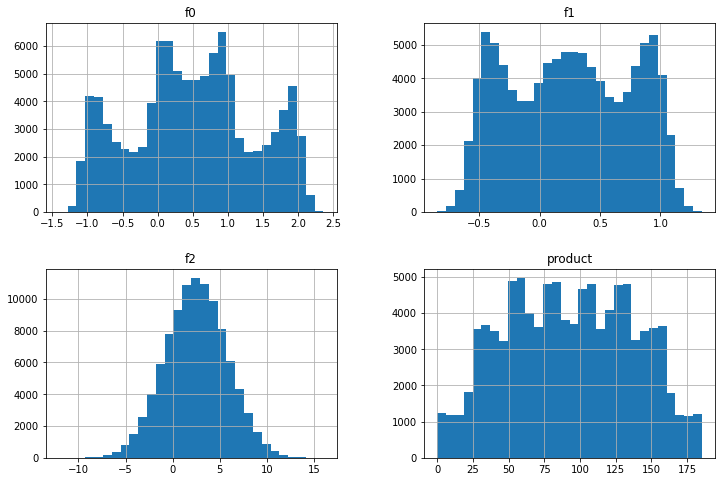

In [13]:
data_1.data.hist(bins=30, figsize=(12,8))
plt.show()

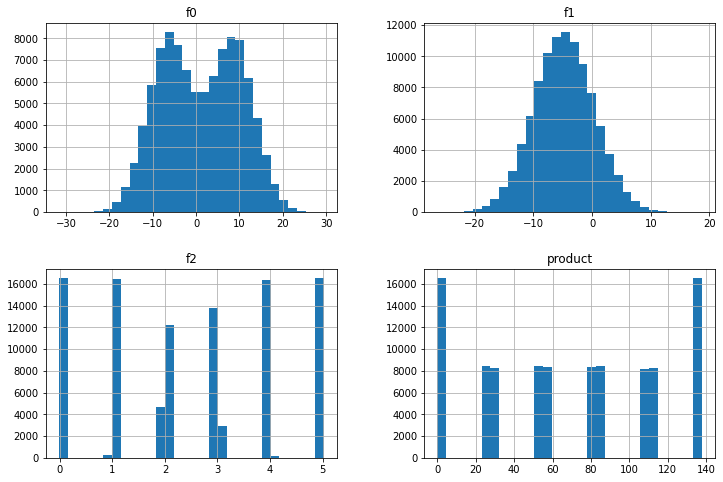

In [14]:
data_2.data.hist(bins=30, figsize=(12,8))
plt.show()

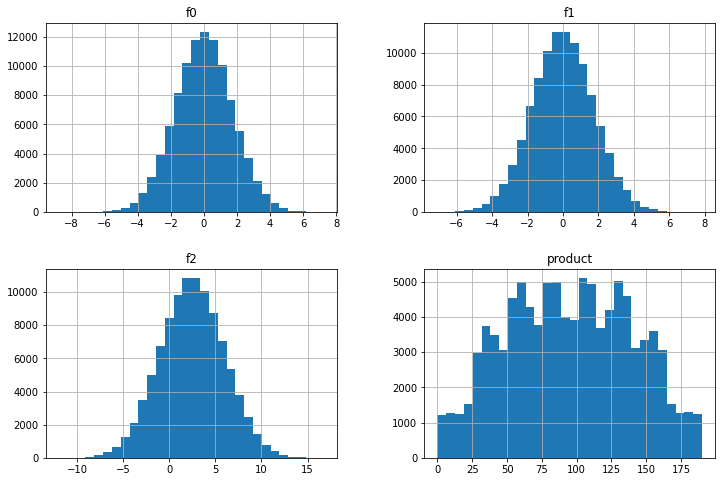

In [15]:
data_3.data.hist(bins=30, figsize=(12,8))
plt.show()

Из графиков распределения параметров можно сделать вывод, что каждый регион имеет свои отличительные особенности. В связи с этим не следует обучать модель по всем регионам, для каждого региона должна быть своя модель.

### <a id='toc1_1_3_'></a>Вывод   [](#toc0_)

Данные представляют собой несколько датасетов, каждый который состоит из нескольких признаков и целевого признака. 

Все три исследуемые нами региона имеют:
1) Три признака - `f0`,`f1`,`f2`;
2) Один целевой признак - `product`;
3) 10000 строк;
4) Не имеют пропусков.

## <a id='toc1_2_'></a>Обучение и проверка модели   [](#toc0_)

### <a id='toc1_2_1_'></a>train_test_split   [](#toc0_)

Разделим выборки на обучающую и валидационую для каждого региона:

In [16]:
for data in oil_well_geo_data.all_oil_well:
    data.train_valid_split()
    print(f'Регион №{data.num_of_region} имеет размер в {data.data.shape[0]} строк')
    print('train_features состоит из {} строк. Процентное соотношение обучающей выборки к полной: {:.0%}'
            .format(data.train_features.shape[0],data.train_features.shape[0]/data.data.shape[0]))
    print('valid_features состоит из {} строк. Процентное соотношение валидационой выборки к полной: {:.0%}'
            .format(data.valid_features.shape[0],data.valid_features.shape[0]/data.data.shape[0]))
    print('*' * 100)
                

Регион №1 имеет размер в 100000 строк
train_features состоит из 75000 строк. Процентное соотношение обучающей выборки к полной: 75%
valid_features состоит из 25000 строк. Процентное соотношение валидационой выборки к полной: 25%
****************************************************************************************************
Регион №2 имеет размер в 100000 строк
train_features состоит из 75000 строк. Процентное соотношение обучающей выборки к полной: 75%
valid_features состоит из 25000 строк. Процентное соотношение валидационой выборки к полной: 25%
****************************************************************************************************
Регион №3 имеет размер в 100000 строк
train_features состоит из 75000 строк. Процентное соотношение обучающей выборки к полной: 75%
valid_features состоит из 25000 строк. Процентное соотношение валидационой выборки к полной: 25%
****************************************************************************************************


### <a id='toc1_2_2_'></a>Scaling   [](#toc0_)

Произведем скалирование признаков:

In [17]:
for data in oil_well_geo_data.all_oil_well:
    data.features_scaling()

### <a id='toc1_2_3_'></a>Обучение Linear Regression   [](#toc0_)

In [18]:
for data in oil_well_geo_data.all_oil_well:
    data.linear_regression()
    print('*' * 100)

После обучения Linear Regression в регионе №1 имеет следующие параметры:
RMSE: 37.6
Среднее предсказанное количество сырья: 92.6
Среднее действительное количество сырья: 92.1
****************************************************************************************************
После обучения Linear Regression в регионе №2 имеет следующие параметры:
RMSE: 0.893
Среднее предсказанное количество сырья: 68.7
Среднее действительное количество сырья: 68.7
****************************************************************************************************
После обучения Linear Regression в регионе №3 имеет следующие параметры:
RMSE: 40.0
Среднее предсказанное количество сырья: 95.0
Среднее действительное количество сырья: 94.9
****************************************************************************************************


### <a id='toc1_2_4_'></a>Вывод:   [](#toc0_)

1) Самая маленькая `Root-Mean-Square-Error` наблюдается у модели для второго региона и составляет `0.893`;
2) Наблюдается сильный дисбаланс среднего количество сырья между регионами. Так в третьем регионе фактическое среднее количество сырья составило `94.9`, что больше на ~40%, чем среднее количество сырья во втором регионе - `68.7`.

## <a id='toc1_3_'></a>Подготовка к расчёту прибыли   [](#toc0_)

Бюджет на разработку скважин в регионе - `10 млрд. рублей`.

Доход с одной единицы - `450 тысяч рублей`. 

По условию задачи, выбираются `200` лучших скважин из `500`.

Следовательно, чтобы точка стала безубыточной и начала приносить прибыль, нужно:

In [19]:
BUDGET = 10 ** 10
ONE_Q_INCOME = 45 * 10 ** 4
SELECTED_Q = 200
break_even_point = BUDGET / ONE_Q_INCOME
break_even_point_q = BUDGET / (ONE_Q_INCOME * SELECTED_Q)
print('Точка безубыточности составляет {:.2f} баррелей;'.format(break_even_point))
print('Средний запас сырья в скважине должен составлять: {:.2f} единиц.'.format(break_even_point_q))

Точка безубыточности составляет 22222.22 баррелей;
Средний запас сырья в скважине должен составлять: 111.11 единиц.


Точка безубыточности достигается при `111.11` единицах сырья в скважине, в то время как в наших данных самое большое количество среднего сырья - `95`.
Посмотрим, какое количество скважин соответствует условию безубыточности:

In [20]:
for data in oil_well_geo_data.all_oil_well:
    max_possible = data.valid_target.sort_values(ascending=False)
    above_thresholds_sorted = max_possible.loc[max_possible > 111.11]
    print('Количество скважин выше заданного порога в 111.11 барралей в регионе №{} составляет: {} скважин. Отношение к общему количество скважин: {:.2%}'
          .format(data.num_of_region,
                  data.human_format(above_thresholds_sorted.count()),
                  above_thresholds_sorted.count() / 25000)
          )

Количество скважин выше заданного порога в 111.11 барралей в регионе №1 составляет: 9.06 тыс. скважин. Отношение к общему количество скважин: 36.24%
Количество скважин выше заданного порога в 111.11 барралей в регионе №2 составляет: 4.19 тыс. скважин. Отношение к общему количество скважин: 16.74%
Количество скважин выше заданного порога в 111.11 барралей в регионе №3 составляет: 9.54 тыс. скважин. Отношение к общему количество скважин: 38.16%


### <a id='toc1_3_1_'></a>Вывод:   [](#toc0_)

Количество среднего сырья в скважинах меньше, чем необходимое количество (`111.11`) для достижения точки безубыточности. Соответствие по регионам:

1) В первом регионе соответствуют `36.24%` скважин;
2) Во втором регионе соответствуют `16.74%` скважин;
3) В третьем регионе соответствуют `38.16%` скважин.


## <a id='toc1_4_'></a>Расчёт прибыли и рисков   [](#toc0_)

### <a id='toc1_4_1_'></a>Прибыль   [](#toc0_)

In [21]:
for data in oil_well_geo_data.all_oil_well:
    data.revenue()
    print(f'В регионе №{data.num_of_region}:')
    print('Количество барралей в выбраных скважинах: {} Прибыль с выбранных скважин: {}'.format(
        data.human_format(data.sum_selected_chosen),
        data.human_format(data.max_profit)))
    print('Максимально возможное количество барралей в регионе: {} Максимальная прибыль в регионе: {}'.format(
        data.human_format(data.sorted_target_sum),
        data.human_format(data.max_possible_profit)))
    print('Разница: {} барралей и {} рублей.'.format(
        data.human_format(data.sum_selected_chosen- data.sorted_target_sum),
        data.human_format(data.max_profit- data.max_possible_profit)))
    print('*' * 100)

В регионе №1:
Количество барралей в выбраных скважинах: 29.6 тыс. Прибыль с выбранных скважин: 3.32 млрд.
Максимально возможное количество барралей в регионе: 36.7 тыс. Максимальная прибыль в регионе: 6.51 млрд.
Разница: -7.09 тыс. барралей и -3.19 млрд. рублей.
****************************************************************************************************
В регионе №2:
Количество барралей в выбраных скважинах: 27.6 тыс. Прибыль с выбранных скважин: 2.42 млрд.
Максимально возможное количество барралей в регионе: 27.6 тыс. Максимальная прибыль в регионе: 2.42 млрд.
Разница: 0  барралей и 0  рублей.
****************************************************************************************************
В регионе №3:
Количество барралей в выбраных скважинах: 28.2 тыс. Прибыль с выбранных скважин: 2.71 млрд.
Максимально возможное количество барралей в регионе: 37.7 тыс. Максимальная прибыль в регионе: 6.94 млрд.
Разница: -9.41 тыс. барралей и -4.23 млрд. рублей.
**************************

### <a id='toc1_4_2_'></a>Вывод   [](#toc0_)

1. Максимальное количество барражей в скважинах в регионе №1 - `29.6 тыс.`. При этом данный показатель меньше на `7 тыс.` баррелей, чем максимально возможное количество;
2. Минимальная разница в регионе №2.

Таким образом, лучшим регионом можно назвать первый регион с максимальной прибылью в `3.32 млрд.`. Оценим риск с помощью техники boostrap.

Это не прибыль а доход

## <a id='toc1_5_'></a>Bootstrap   [](#toc0_)

In [22]:
for data in oil_well_geo_data.all_oil_well:
    data.bootstrap()
    print('*' * 100)

В регионе №1:
Среднее значение выручки: 396 милл.
Доверительный интервал 95% для средней выручки лежит между 380 милл. - 413 милл.
Возможный убыток варьируется от: -370 милл. до -2.35 милл.
Риск убытка составляет : 6.90%
****************************************************************************************************
В регионе №2:
Среднее значение выручки: 456 милл.
Доверительный интервал 95% для средней выручки лежит между 443 милл. - 469 милл.
Возможный убыток варьируется от: -192 милл. до -6.73 милл.
Риск убытка составляет : 1.50%
****************************************************************************************************
В регионе №3:
Среднее значение выручки: 404 милл.
Доверительный интервал 95% для средней выручки лежит между 387 милл. - 421 милл.
Возможный убыток варьируется от: -418 милл. до -751 тыс.
Риск убытка составляет : 7.60%
****************************************************************************************************


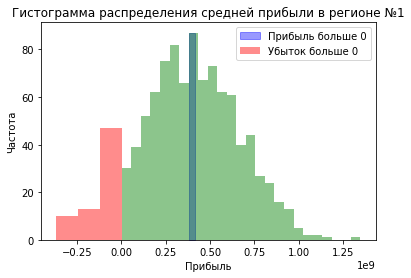

In [23]:
data_1.plot_values()

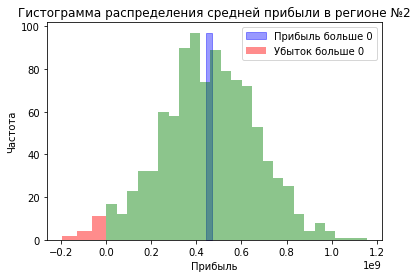

In [24]:
data_2.plot_values()

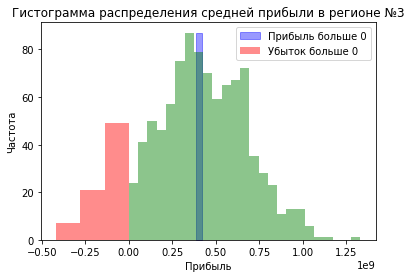

In [25]:
data_3.plot_values()

### <a id='toc1_5_1_'></a>Вывод:   [](#toc0_)

Наилучший регион №1 после оценки модели имеет наихудшие результаты после применения техники `Bootstrap`.

1. Лучшая средняя выручка у региона №2 - `456 милл.`, на втором месте регион №3 - `404 милл.`, на третьем - `396 милл.`;
2. Наилучший диапазон `95%` доверительного интервала у региона №2;
3. Риск убытков в регионах:
    - Регион №1: от `-370 милл.` - до `-2.35 милл.` с вероятностью в `6.90%`;
    - Регион №2: от `-192 милл.` - до `-6.73 милл.` с вероятностью в `1.50%`;
    - Регион №3: от `-418 милл.` - до `-751 тыс.` с вероятностью в `7.60%`.

Из условия задачи, нам нужен регион с риском < `2.5%`. Таким образом, остаются только один региона: второй.

Можно заключить, что второй регион наилучший по параметру риск/прибыль => это наилучший регион для добычи. 

## <a id='toc1_6_'></a>Вывод   [](#toc0_)

##### <a id='toc1_6_1_1_1_'></a>a. Обработка данных   [](#toc0_)
Данные представляют собой несколько датасетов, каждый который состоит из нескольких признаков и целевого признака. 

Три исследуемые нами региона имеют:
- Три признака - `f0`,`f1`,`f2`;
- Один целевой признак - `product`;
- 10000 строк;
- Не имеют пропусков и дубликатов.

##### <a id='toc1_6_1_1_2_'></a>b. Разделение данных и обучение модели   [](#toc0_)

Данные по регионам были распределены на тренировачную и тестовую выборку. Признаки были отскалированы, для прогнозирования была выбрана модель Linear Regression.

После обучения модели получились следующие результаты:

- Самая маленькая `Root-Mean-Square-Error` наблюдается у модели для второго региона и составляет `0.893`;
- Наибольшее количество среднего сырья наблюдается в регионе №3 - `95`, наименьшее - в регионе №2 и составляет `68.7`;
- Наблюдается сильный дисбаланс среднего количество сырья между регионами. Так в третьем регионе фактическое среднее количество сырья составило `94.9`, что больше на ~40%, чем среднее количество сырья во втором регионе - `68.7`.

##### <a id='toc1_6_1_1_3_'></a>c. Подготовительные расчеты   [](#toc0_)

Было рассчитано необходимое среднее количество сырья в скважинах, для достижения точки безубыточности: `111.11` барралей. 
Количество среднего сырья в скважинах меньше, чем необходимое количество. Соответствие по регионам:

-  В первом регионе соответствуют `36.24%` скважин;
-  Во втором регионе соответствуют `16.74%` скважин;
-  В третьем регионе соответствуют `38.16%` скважин.

##### <a id='toc1_6_1_1_4_'></a>d. Работа модели на тестовых данных   [](#toc0_)

Обученная модель была протестирована на тестовых данных. Были получены следующие результаты:

-  Максимальное количество барражей в скважинах в регионе №1 - `29.6 тыс.`. При этом данный показатель меньше на `7 тыс.` баррелей, чем максимально возможное количество;
-  Минимальная разница в регионе №2.

Таким образом, лучшим регионом можно назвать первый регион с максимальной прибылью в `3.32 млрд.`.

##### <a id='toc1_6_1_1_5_'></a>f. Bootstrap   [](#toc0_)

После оценки регионов с помощью техники `Bootstrap` были получены следующие результаты:


1. Лучшая средняя выручка у региона №2 - `456 милл.`, на втором месте регион №3 - `404 милл.`, на третьем - `396 милл.`;
2. Наилучший диапазон `95%` доверительного интервала у региона №2;
3. Риск убытков в регионах:
    - Регион №1: от `-370 милл.` - до `-2.35 милл.` с вероятностью в `6.90%`;
    - Регион №2: от `-192 милл.` - до `-6.73 милл.` с вероятностью в `1.50%`;
    - Регион №3: от `-418 милл.` - до `-751 тыс.` с вероятностью в `7.60%`.

Из условия задачи, нам нужен регион с риском < `2.5%`. Таким образом, остается только один регион: второй.

Можно заключить, что `второй регион` наилучший по параметру риск/прибыль => это `наилучший регион` для добычи.